In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost

class FixableDataFrame(pd.DataFrame):
    """ Helper class for manipulating generative models.
    """
    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super(FixableDataFrame, self).__init__(*args, **kwargs)
    def __setitem__(self, key, value):
        out = super(FixableDataFrame, self).__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super(FixableDataFrame, self).__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

# generate the data
def generator(n, fixed={}, seed=0):
    """ The generative model for our subscriber retention example.
    """
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # the number of sales calls made to this customer
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # the number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # the health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # the time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # how much the user perceives that they need the product
    X["Product need"] = (X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,)))

    # the fractional discount offered to this customer upon renewal
    X["Discount"] = ((1-scipy.special.expit(X["Product need"])) * 0.5 + 0.5 * np.random.uniform(0, 1, size=(n,))) / 2

    # What percent of the days in the last period was the user actively using the product
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,)))

    # how much ad money we spent per user targeted at this user (or a group this user is in)
    X["Ad spend"] = X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,)) + (X["Last upgrade"] < 1) + (X["Last upgrade"] < 2)

    # how many bugs did this user encounter in the since their last renewal
    X["Bugs faced"] = np.array([np.random.poisson(v*2) for v in X["Monthly usage"]])

    # how many bugs did the user report?
    X["Bugs reported"] = (X["Bugs faced"] * scipy.special.expit(X["Product need"])).round()

    # did the user renew?
    X["Did renew"] = scipy.special.expit(7 * (
          0.18 * X["Product need"] \
        + 0.08 * X["Monthly usage"] \
        + 0.1 * X["Economy"] \
        + 0.05 * X["Discount"] \
        + 0.05 * np.random.normal(0, 1, size=(n,)) \
        + 0.05 * (1 - X['Bugs faced'] / 20) \
        + 0.005 * X["Sales calls"] \
        + 0.015 * X["Interactions"] \
        + 0.1 / (X["Last upgrade"]/4 + 0.25)
        + X["Ad spend"] * 0.0 - 0.45
    ))

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Uncomment this line to get
    # noiser causal effect lines but the same basic results
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X

def user_retention_dataset():
    """ The observed data for model training.
    """
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y

def fit_xgboost(X, y):
    """ Train an XGBoost model with early stopping.
    """
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        { "eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"}, dtrain, num_boost_round=200000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    return model

In [3]:
X, y = user_retention_dataset()
model = fit_xgboost(X, y)

/Users/spaccs01/workspace/playground/machine-learning-playground/.python/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/spaccs01/workspace/playground/machine-learning-playground/.python/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-o

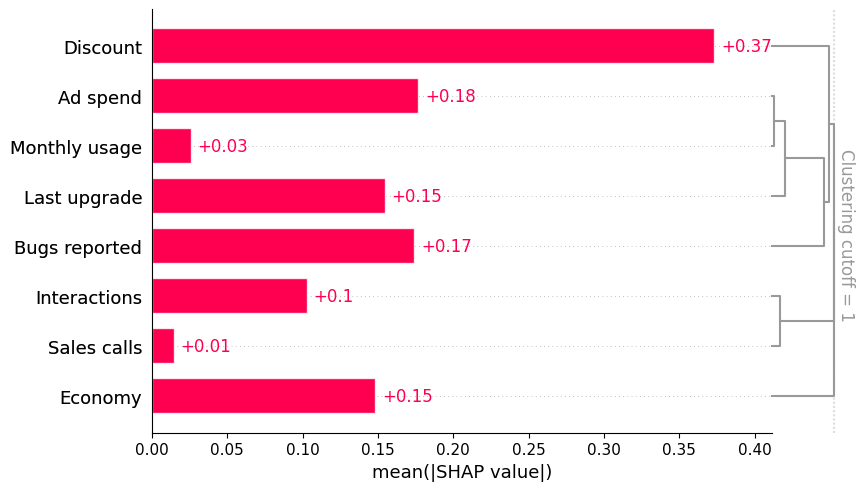

In [5]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

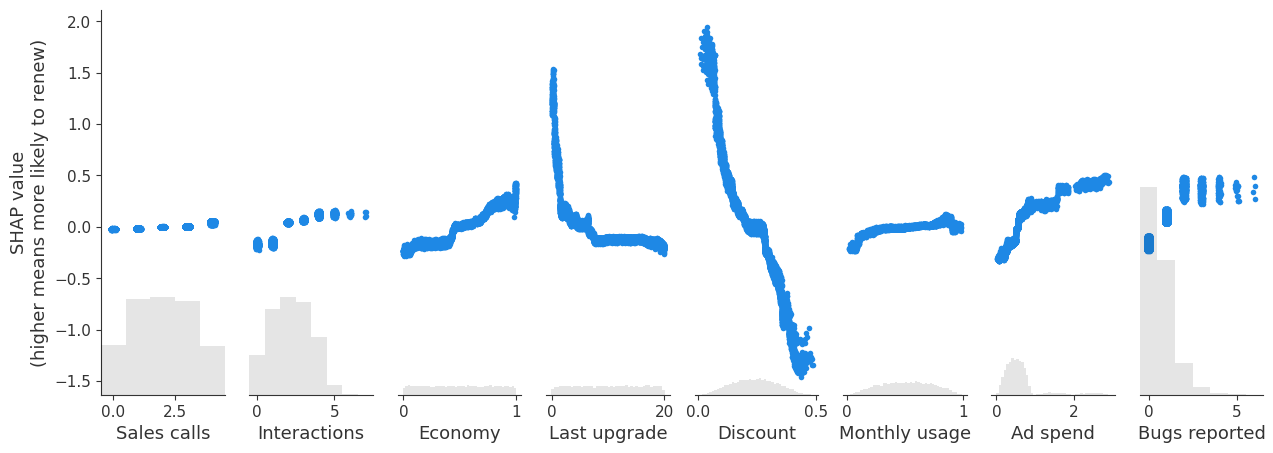

In [6]:
shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")

In [8]:
import graphviz
names = [
         "Bugs reported", "Monthly usage", "Sales calls", "Economy",
         "Discount", "Last upgrade", "Ad spend", "Interactions"
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Did renew", style="filled", fontsize="10")

g.edge("Product need", "Did renew")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Did renew")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Did renew")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Did renew")
g.edge("Sales calls", "Did renew")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Did renew")
g.edge("Bugs faced", "Did renew")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Did renew")
g.edge("Last upgrade", "Ad spend")
g

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH